cuda:0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 59.9 MB
epoch =  1
counter =  10000
counter =  20000


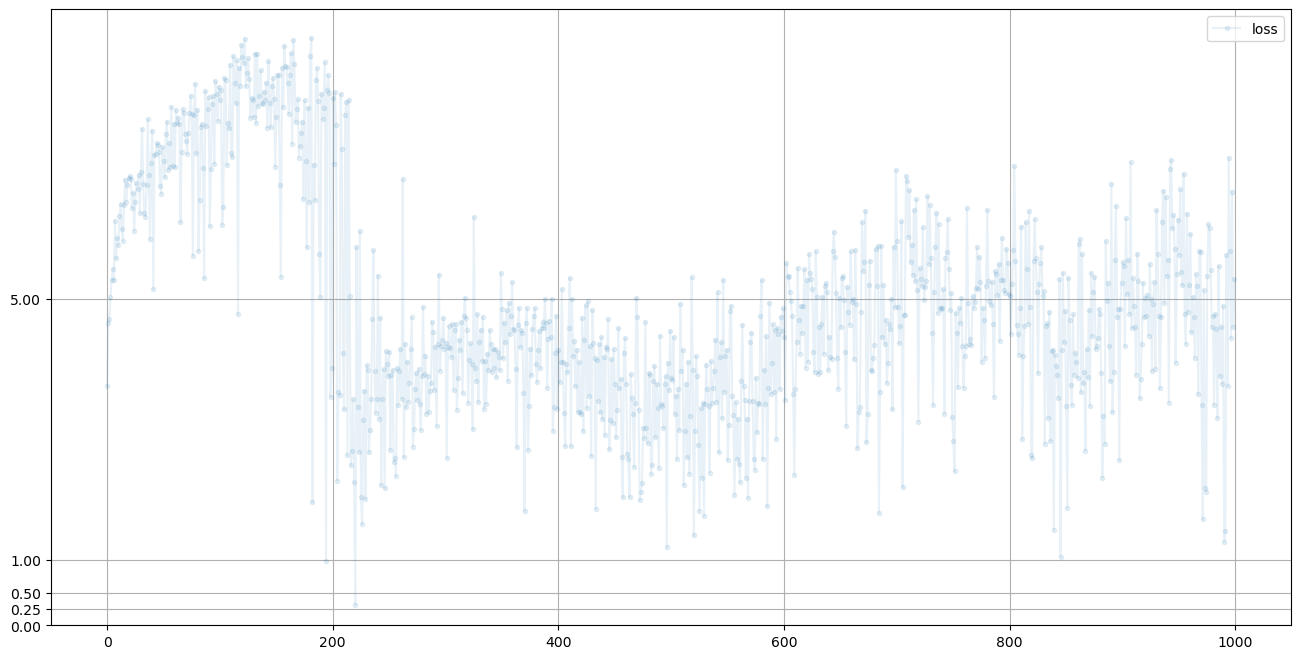

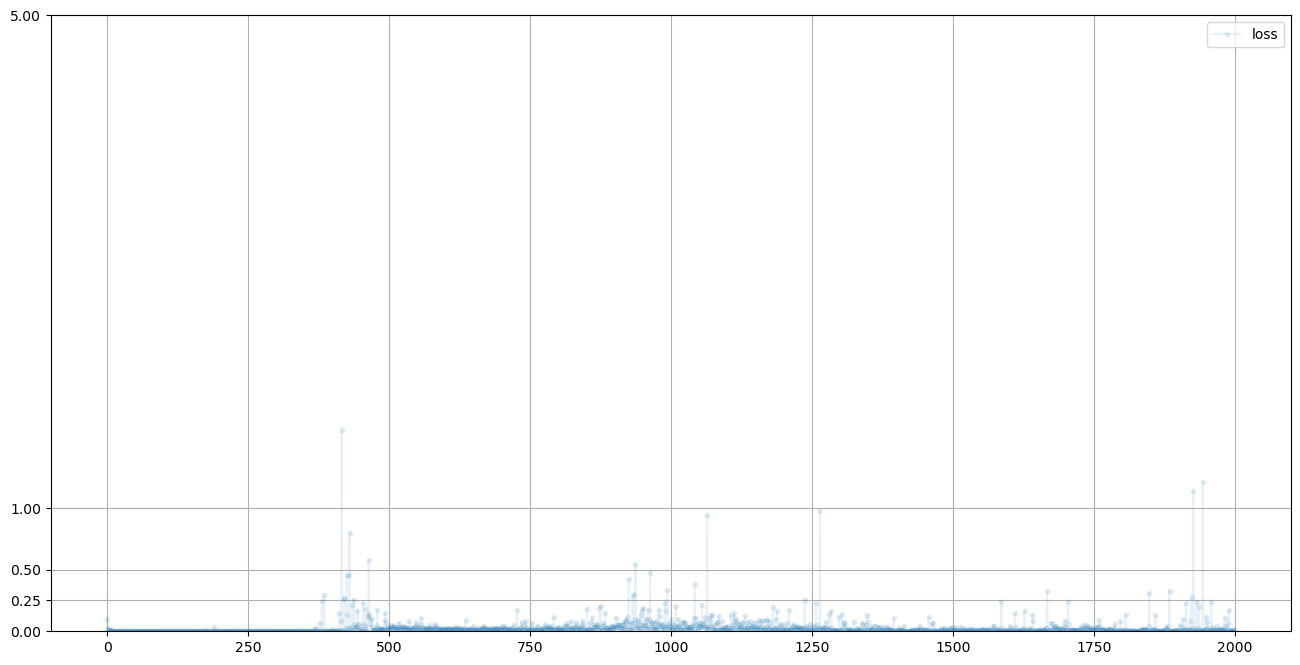

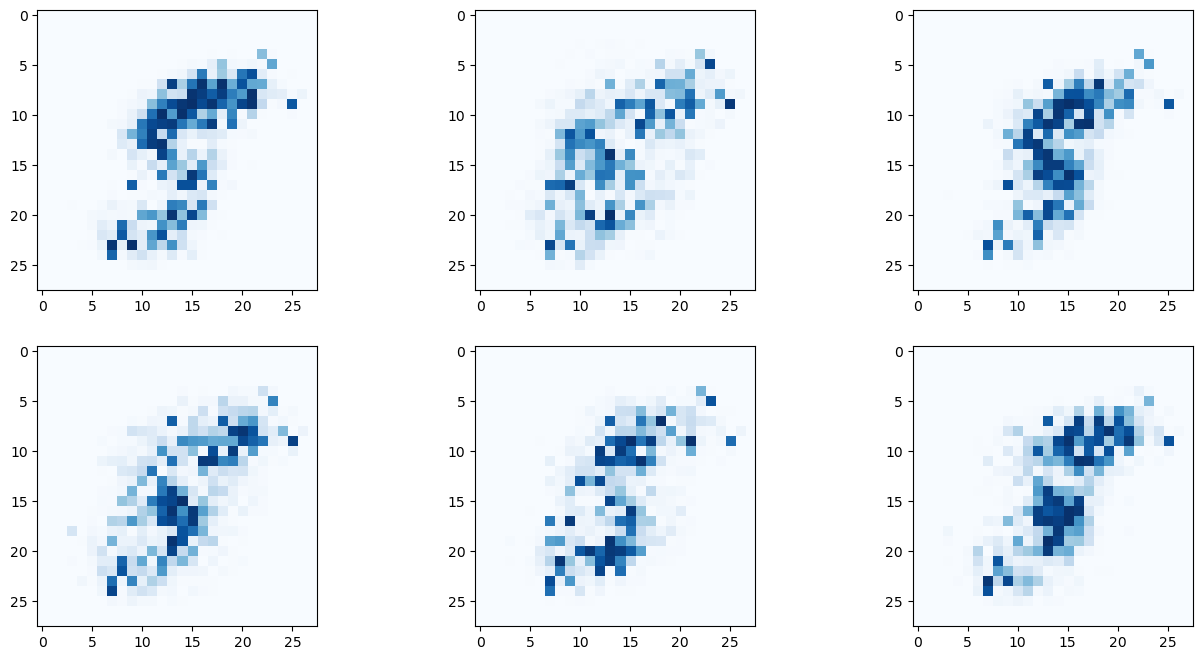

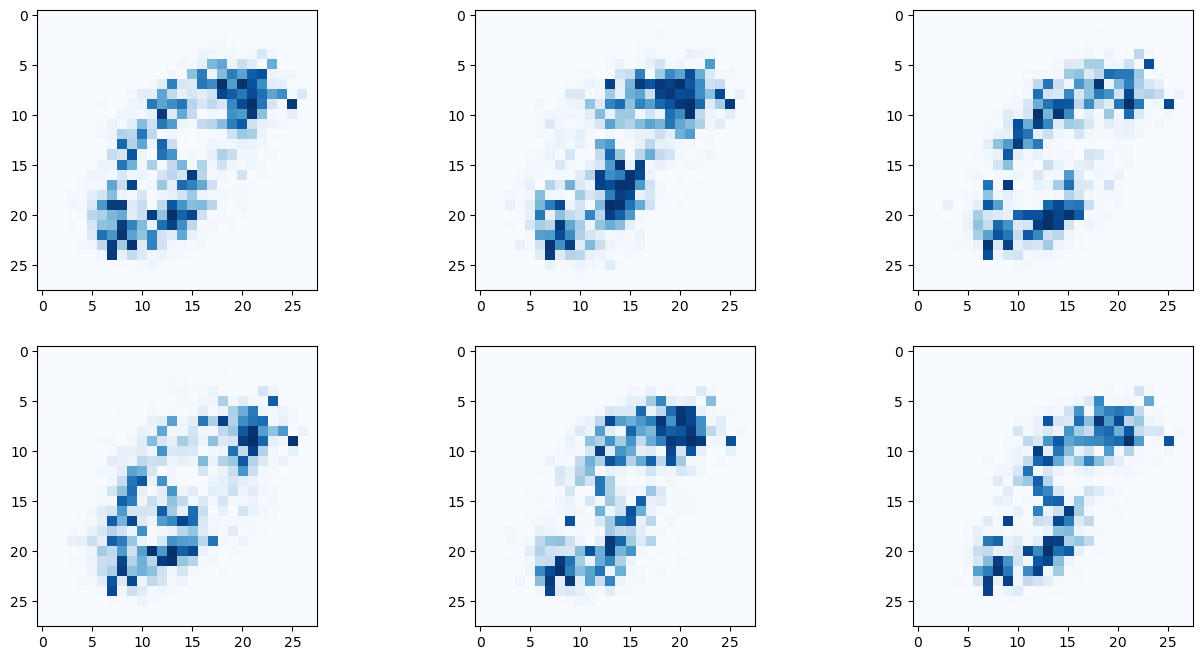

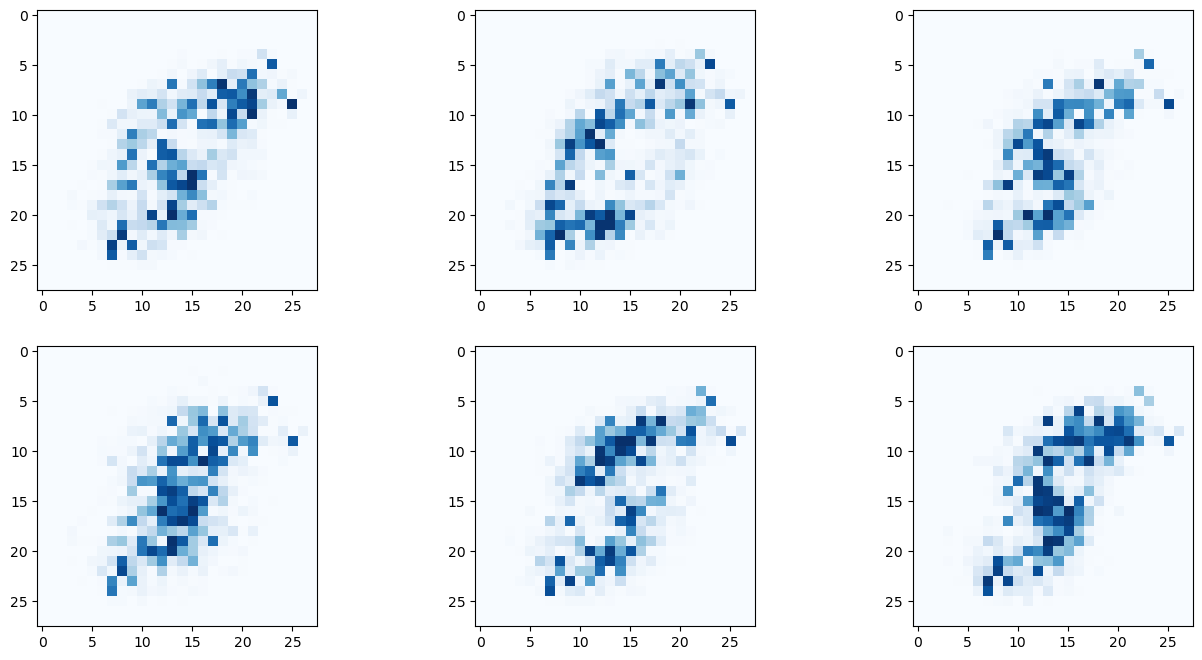

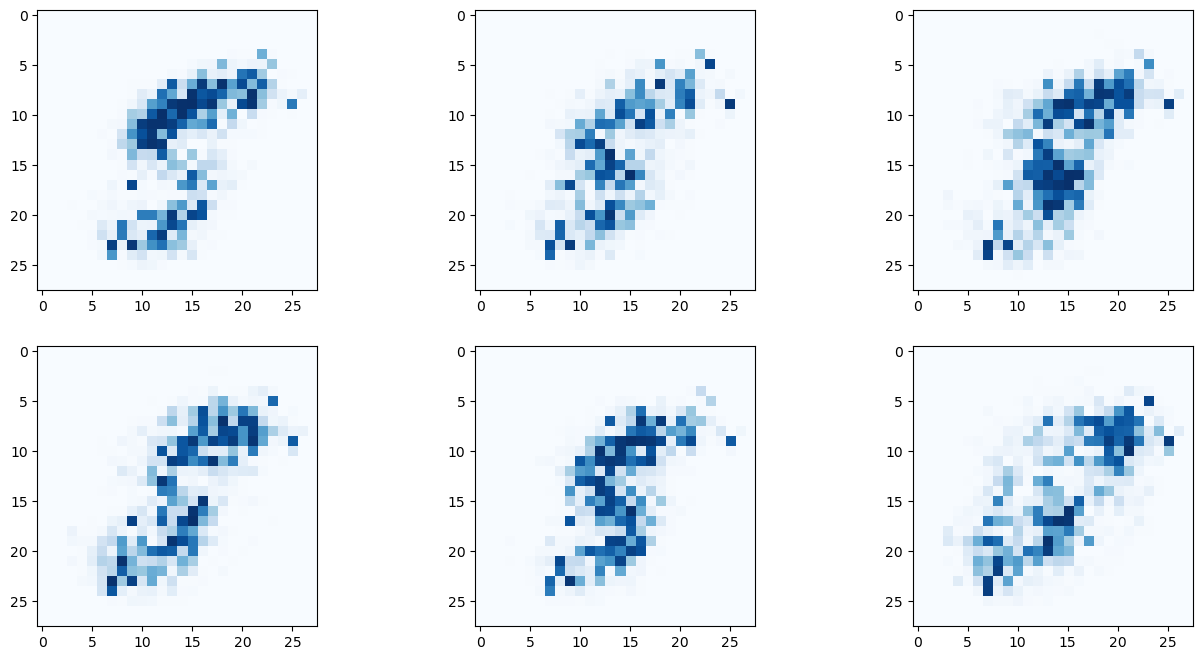

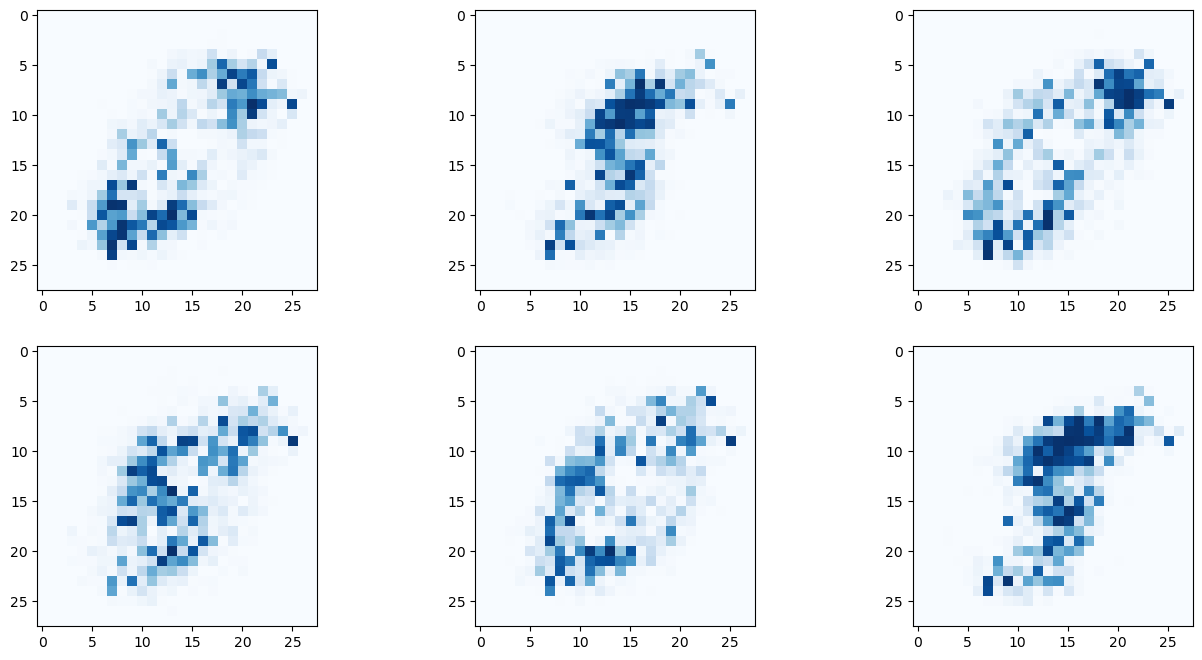

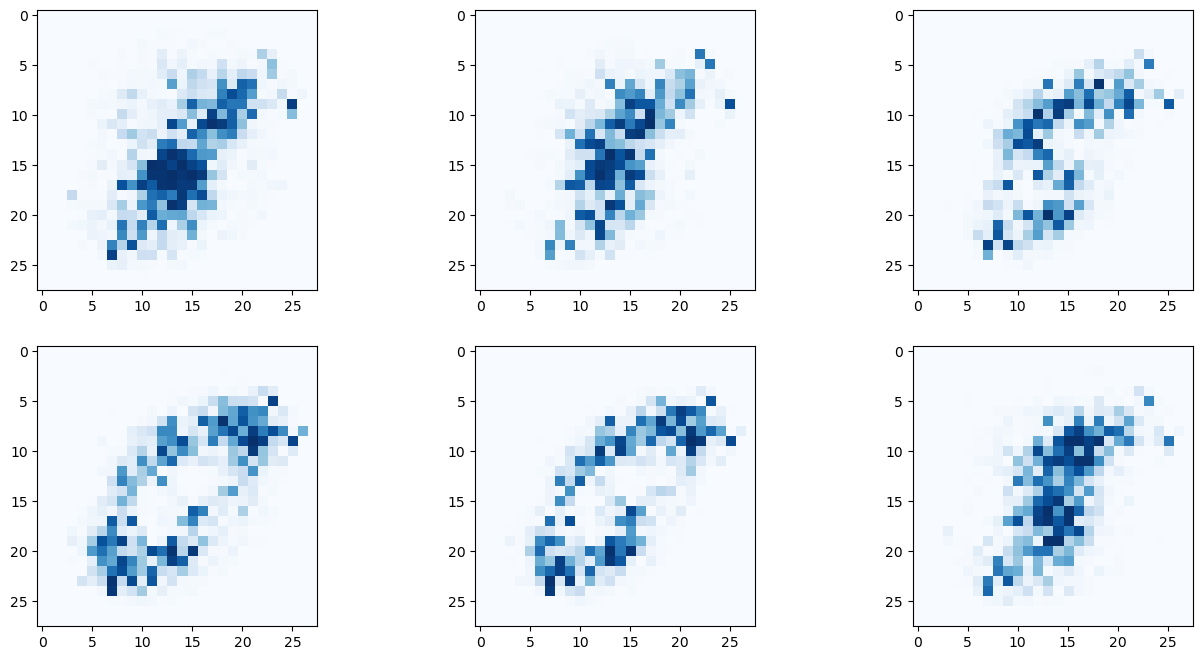

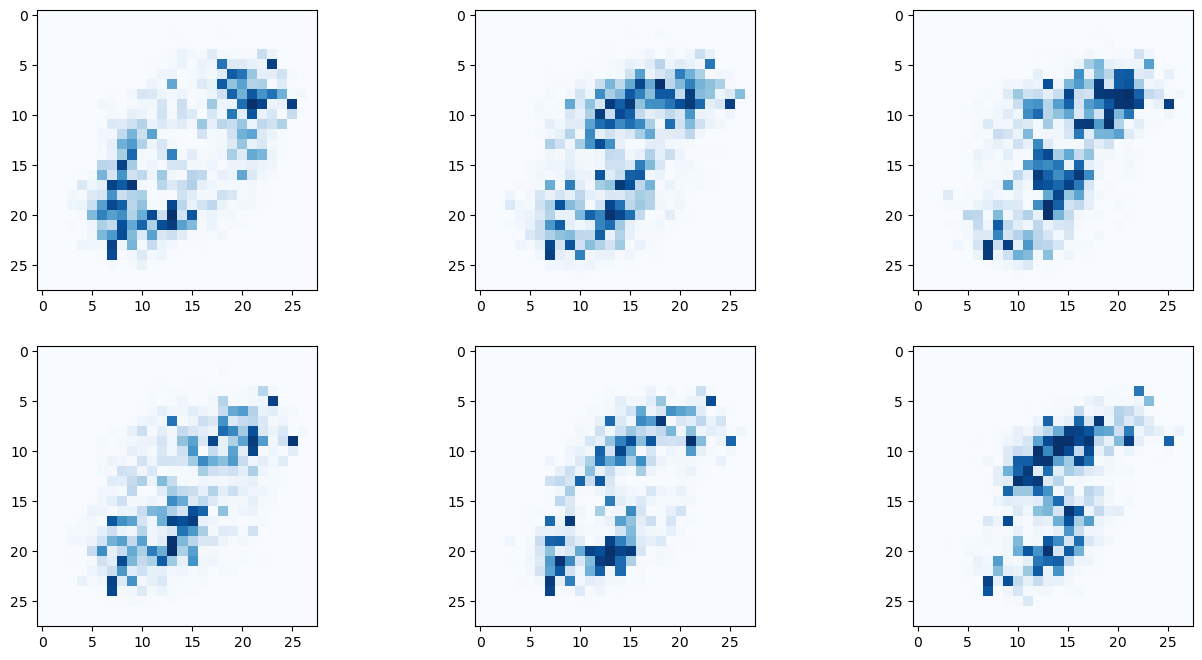

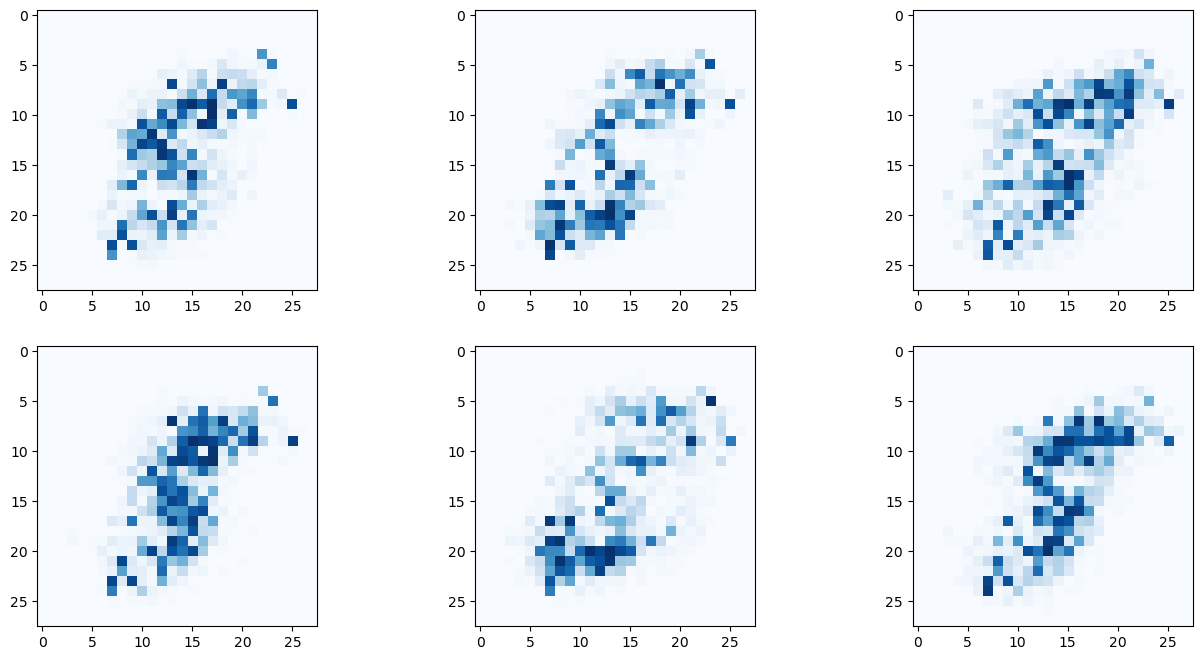

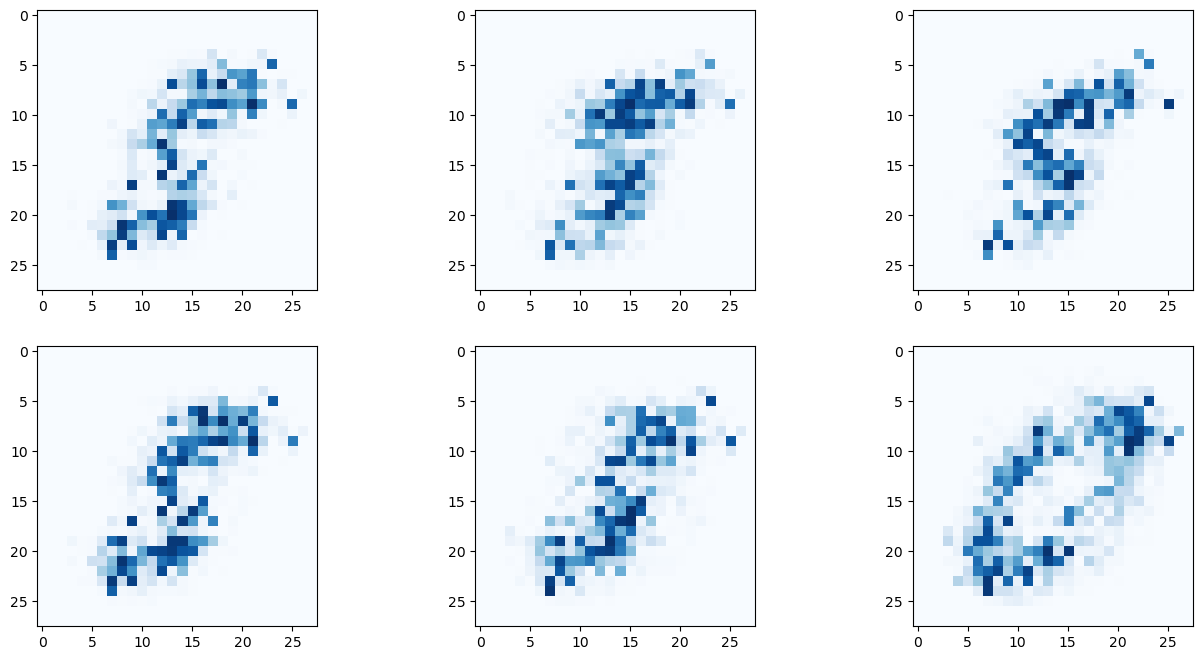

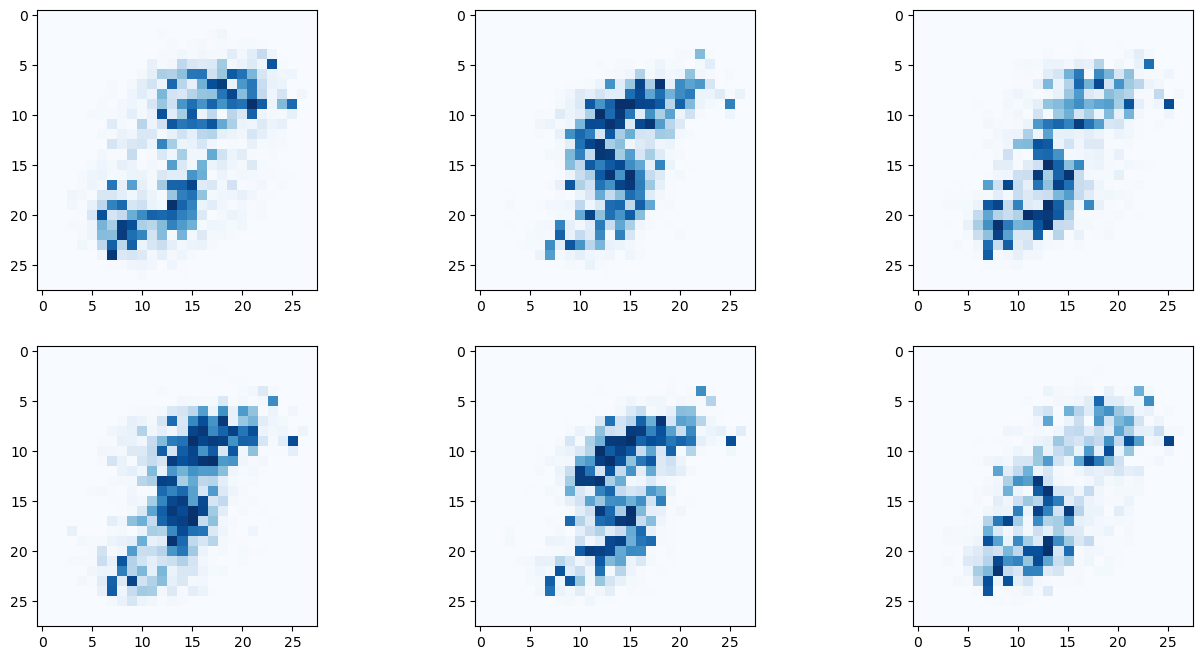

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, low_memory=False)
        self.data_df.info()
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = torch.tensor(self.data_df.iloc[index,0])
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')

def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = np.random.choice(size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor

class Discriminator(nn.Module):
    
    def __init__(self, device):
        # initialise parent pytorch class
        super().__init__()
        self.device = device
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784+10, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, image_tensor, label_tensor):
        image_tensor = image_tensor.to(self.device)
        label_tensor = label_tensor.to(self.device)
        # combine seed and label
        inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)
    
    
    def train(self, inputs, label_tensor, targets):
        inputs = inputs.to(self.device)
        label_tensor = label_tensor.to(self.device)
        targets = targets.to(self.device)
        # calculate the output of the network
        outputs = self.forward(inputs, label_tensor)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

class Generator(nn.Module):
    
    def __init__(self, device):
        # initialise parent pytorch class
        super().__init__()
        self.device = device
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100+10, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, seed_tensor, label_tensor): 
        seed_tensor = seed_tensor.to(self.device) 
        label_tensor = label_tensor.to(self.device)  
        # combine seed and label
        inputs = torch.cat((seed_tensor, label_tensor))
        return self.model(inputs)


    def train(self, D, inputs, label_tensor, targets):
        inputs = inputs.to(self.device)
        label_tensor = label_tensor.to(self.device)
        targets = targets.to(self.device)
        # calculate the output of the network
        g_output = self.forward(inputs, label_tensor)
        
        # pass onto Discriminator
        d_output = D.forward(g_output, label_tensor)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def plot_images(self, label):
        label_tensor = torch.zeros((10))
        label_tensor[label] = 1.0
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(torch.randn(100), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
                pass
            pass
        pass
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass



if __name__ == '__main__':
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)

    mnist_dataset = MnistDataset('~/dataset/MNIST/mnist_test.csv')

    # 训练GAN
    D = Discriminator(device).to(device)
    G = Generator(device).to(device)

    # 训练鉴别器和生成器
    epochs = 1

    for epoch in range(epochs):
        print("epoch = ", epoch + 1)

        # train Discriminator and Generator

        for label, image_data_tensor, label_tensor in mnist_dataset:
            # train discriminator on true
            D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))

            # random 1-hot label for generator
            random_label = generate_random_one_hot(10)
            
            # train discriminator on false
            # use detach() so gradients in G are not calculated
            D.train(G.forward(torch.randn(100), random_label).detach(), random_label, torch.FloatTensor([0.0]))
            
            # different random 1-hot label for generator
            random_label = generate_random_one_hot(10)

            # train generator
            G.train(D, torch.randn(100), random_label, torch.FloatTensor([1.0]))

            pass
            
        pass
        

    G.plot_progress()
    D.plot_progress()

    #输出一个最终学习结果
    for i in range(10):
        G.plot_images(i)

